In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional


In [2]:
# === CONFIG ===
DATA_PROC = "/Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed"
OUT_DIR = os.path.join(DATA_PROC, "sindy_out")
os.makedirs(OUT_DIR, exist_ok=True)

DT = 1.0  # TODO: set this to the true sampling dt of your synthetic signals (or keep 1.0 if unknown)
SEED = 0
np.random.seed(SEED)

print("DATA_PROC:", DATA_PROC)
print("OUT_DIR:", OUT_DIR)


DATA_PROC: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed
OUT_DIR: /Users/apple/Documents/Computational Neuroscience Paris Saclay/Supervised projects/main/code/data/processed/sindy_out


In [3]:
def load_latent(which: str) -> np.ndarray:
    """
    which:
      - "hopf_hdmd"  -> Z_hopf_Sch100_HDMDdyn_r2.npy (shape ~ (9996, 2))
      - "hopf_dmd"   -> Z_hopf_Sch100_DMDdyn_r10.npy (shape ~ (20000, 20))
      - "diff_dmd"   -> Z_diff_Sch100_<case>_DMDdyn_r10.npy (shape ~ (1000, 20))
    """
    if which == "hopf_hdmd":
        fname = "Z_hopf_Sch100_HDMDdyn_r2.npy"
    elif which == "hopf_dmd":
        fname = "Z_hopf_Sch100_DMDdyn_r10.npy"
    elif which == "diff_dmd":
        # choose the diffusion case used in DMD notebook: noise01/noise001/noise0
        DIFF_CASE = "noise01"
        fname = f"Z_diff_Sch100_{DIFF_CASE}_DMDdyn_r10.npy"
    else:
        raise ValueError("Unknown latent selection.")

    path = os.path.join(DATA_PROC, fname)
    Z = np.load(path)
    print("Loaded:", fname, "shape:", Z.shape)
    return Z

Z = load_latent("hopf_hdmd")  # <-- change this to run other cases


Loaded: Z_hopf_Sch100_HDMDdyn_r2.npy shape: (9996, 4)


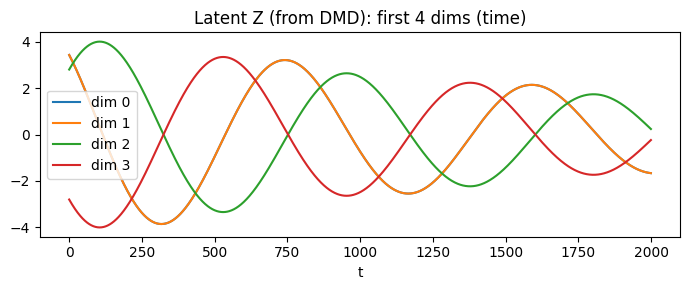

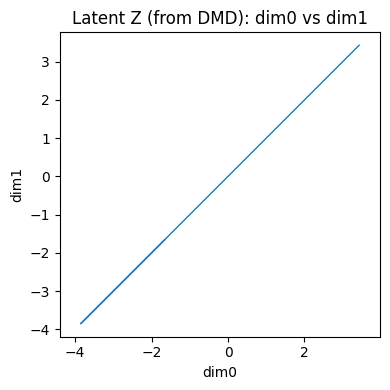

In [4]:
def qc_plots(Z: np.ndarray, max_dims: int = 4, T_plot: int = 2000, title: str = "Z"):
    T = Z.shape[0]
    Tp = min(T_plot, T)
    d = min(max_dims, Z.shape[1])

    plt.figure(figsize=(7,3))
    for i in range(d):
        plt.plot(Z[:Tp, i], label=f"dim {i}")
    plt.title(f"{title}: first {d} dims (time)")
    plt.xlabel("t")
    plt.legend()
    plt.tight_layout()
    plt.show()

    if Z.shape[1] >= 2:
        plt.figure(figsize=(4,4))
        plt.plot(Z[:Tp, 0], Z[:Tp, 1], lw=1)
        plt.title(f"{title}: dim0 vs dim1")
        plt.xlabel("dim0")
        plt.ylabel("dim1")
        plt.axis("equal")
        plt.tight_layout()
        plt.show()

qc_plots(Z, title="Latent Z (from DMD)")


In [5]:
def zscore(Z: np.ndarray, eps: float = 1e-12):
    mu = Z.mean(axis=0, keepdims=True)
    sd = Z.std(axis=0, keepdims=True)
    Zs = (Z - mu) / (sd + eps)
    return Zs, mu, sd

Zs, Z_mu, Z_sd = zscore(Z)

np.save(os.path.join(OUT_DIR, "Z_used.npy"), Zs)
np.save(os.path.join(OUT_DIR, "Z_mean.npy"), Z_mu)
np.save(os.path.join(OUT_DIR, "Z_std.npy"), Z_sd)

print("Zs shape:", Zs.shape)


Zs shape: (9996, 4)


In [6]:
def finite_difference(Z: np.ndarray, dt: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Returns:
      Z_mid: (T-2, d) aligned states
      dZdt:  (T-2, d) central-difference derivatives
    """
    dZdt = (Z[2:] - Z[:-2]) / (2*dt)
    Z_mid = Z[1:-1]
    return Z_mid, dZdt

Z_fit, dZdt = finite_difference(Zs, DT)

np.save(os.path.join(OUT_DIR, "dZdt.npy"), dZdt)
print("Z_fit:", Z_fit.shape, "dZdt:", dZdt.shape)


Z_fit: (9994, 4) dZdt: (9994, 4)


In [7]:
def time_split(Z: np.ndarray, dZdt: np.ndarray, train_frac: float = 0.7):
    T = Z.shape[0]
    n_tr = int(train_frac * T)
    return (Z[:n_tr], dZdt[:n_tr]), (Z[n_tr:], dZdt[n_tr:])

(Z_tr, dZ_tr), (Z_va, dZ_va) = time_split(Z_fit, dZdt, train_frac=0.7)
print("Train:", Z_tr.shape, "Val:", Z_va.shape)


Train: (6995, 4) Val: (2999, 4)


In [8]:
def build_library(Z: np.ndarray, poly_order: int = 3, include_constant: bool = True) -> Tuple[np.ndarray, List[str]]:
    """
    Simple polynomial library up to given order.
    Includes monomials of individual variables only (no cross-terms) to keep it conservative.
    You can extend to cross-terms later if needed.
    """
    T, d = Z.shape
    cols = []
    names = []

    if include_constant:
        cols.append(np.ones((T, 1)))
        names.append("1")

    # linear
    cols.append(Z)
    names += [f"z{i}" for i in range(d)]

    # higher powers (no cross terms)
    for p in range(2, poly_order+1):
        cols.append(Z**p)
        names += [f"z{i}^{p}" for i in range(d)]

    Theta = np.concatenate(cols, axis=1)
    return Theta, names

Theta_tr, names = build_library(Z_tr, poly_order=3, include_constant=True)
Theta_va, _ = build_library(Z_va, poly_order=3, include_constant=True)

print("Theta_tr:", Theta_tr.shape, "features:", len(names))
print("First 10 names:", names[:10])


Theta_tr: (6995, 13) features: 13
First 10 names: ['1', 'z0', 'z1', 'z2', 'z3', 'z0^2', 'z1^2', 'z2^2', 'z3^2', 'z0^3']


In [9]:
def stlsq(Theta: np.ndarray, dZdt: np.ndarray, lam: float, n_iter: int = 10) -> np.ndarray:
    """
    Sequentially Thresholded Least Squares (STLSQ).
    Solves dZdt ≈ Theta @ Xi, with sparsity induced by threshold lam.
    """
    # initial least squares
    Xi, *_ = np.linalg.lstsq(Theta, dZdt, rcond=None)

    for _ in range(n_iter):
        small = np.abs(Xi) < lam
        Xi[small] = 0.0

        # refit each state dimension on remaining active terms
        for k in range(dZdt.shape[1]):
            active = ~small[:, k]
            if active.sum() == 0:
                continue
            Xi_active, *_ = np.linalg.lstsq(Theta[:, active], dZdt[:, k], rcond=None)
            Xi[active, k] = Xi_active

    return Xi

def nnz(Xi: np.ndarray) -> int:
    return int(np.sum(np.abs(Xi) > 0))

def deriv_fit_mse(Theta: np.ndarray, dZdt: np.ndarray, Xi: np.ndarray) -> float:
    resid = dZdt - Theta @ Xi
    return float(np.mean(resid**2))


In [10]:
lam_grid = np.logspace(-8, -2, 13)  # adjust later if needed
results = []

for lam in lam_grid:
    Xi = stlsq(Theta_tr, dZ_tr, lam=lam, n_iter=10)
    tr_mse = deriv_fit_mse(Theta_tr, dZ_tr, Xi)
    va_mse = deriv_fit_mse(Theta_va, dZ_va, Xi)
    results.append({
        "lam": float(lam),
        "nnz": nnz(Xi),
        "train_mse": tr_mse,
        "val_mse": va_mse,
        "Xi": Xi
    })

# quick view
for r in results[:5]:
    print(r["lam"], "nnz", r["nnz"], "val_mse", r["val_mse"])


1e-08 nnz 20 val_mse 7.299256651882472e-33
3.162277660168379e-08 nnz 20 val_mse 7.299256651882472e-33
1e-07 nnz 20 val_mse 7.299256651882472e-33
3.162277660168379e-07 nnz 20 val_mse 7.299256651882472e-33
1e-06 nnz 20 val_mse 7.299256651882472e-33


In [11]:
def rhs(z: np.ndarray, Xi: np.ndarray, poly_order: int = 3) -> np.ndarray:
    """
    z: (d,) current state
    returns dz/dt: (d,)
    Uses the same no-cross-term polynomial library as build_library.
    """
    d = z.shape[0]
    feats = [1.0]  # constant

    feats += list(z)  # linear
    for p in range(2, poly_order+1):
        feats += list(z**p)

    theta = np.array(feats)  # (n_features,)
    dz = theta @ Xi  # (d,)
    return dz

def euler_rollout(z0: np.ndarray, Xi: np.ndarray, T: int, dt: float, poly_order: int = 3) -> np.ndarray:
    Zhat = np.zeros((T, z0.shape[0]))
    Zhat[0] = z0
    for t in range(1, T):
        Zhat[t] = Zhat[t-1] + dt * rhs(Zhat[t-1], Xi, poly_order=poly_order)
    return Zhat

def rollout_rmse(Z_true: np.ndarray, Z_hat: np.ndarray) -> float:
    T = min(Z_true.shape[0], Z_hat.shape[0])
    return float(np.sqrt(np.mean((Z_true[:T] - Z_hat[:T])**2)))

# rollout on validation segment
poly_order = 3
Tva = Z_va.shape[0]
z0 = Z_va[0].copy()

for r in results:
    Xi = r["Xi"]
    Zhat = euler_rollout(z0, Xi, T=Tva, dt=DT, poly_order=poly_order)
    r["rollout_rmse"] = rollout_rmse(Z_va, Zhat)
    r["stable"] = bool(np.all(np.isfinite(Zhat)) and (np.max(np.abs(Zhat)) < 1e3))


In [12]:
# filter stable models
stable = [r for r in results if r["stable"]]
stable_sorted = sorted(stable, key=lambda x: (x["rollout_rmse"], x["nnz"]))

best = stable_sorted[0]
print("BEST:")
print(" lam:", best["lam"])
print(" nnz:", best["nnz"])
print(" rollout_rmse:", best["rollout_rmse"])

# save all results (without huge duplication)
save_pack = {
    "lam_grid": [r["lam"] for r in results],
    "nnz": [r["nnz"] for r in results],
    "train_mse": [r["train_mse"] for r in results],
    "val_mse": [r["val_mse"] for r in results],
    "rollout_rmse": [r.get("rollout_rmse", np.nan) for r in results],
    "stable": [r.get("stable", False) for r in results],
}
with open(os.path.join(OUT_DIR, "sweep_metrics.json"), "w") as f:
    json.dump(save_pack, f, indent=2)

np.save(os.path.join(OUT_DIR, "Xi_best.npy"), best["Xi"])
print("Saved Xi_best.npy and sweep_metrics.json")


BEST:
 lam: 1e-08
 nnz: 20
 rollout_rmse: 0.001900635536889864
Saved Xi_best.npy and sweep_metrics.json


In [13]:
def pretty_equations(Xi: np.ndarray, names: List[str], thresh: float = 0.0) -> List[str]:
    eqs = []
    for k in range(Xi.shape[1]):
        terms = []
        for j, coef in enumerate(Xi[:, k]):
            if abs(coef) > thresh:
                terms.append(f"{coef:+.3e}*{names[j]}")
        rhs_str = " ".join(terms) if terms else "0"
        eqs.append(f"dz{k}/dt = {rhs_str}")
    return eqs

eqs = pretty_equations(best["Xi"], names, thresh=0.0)
for e in eqs:
    print(e)


dz0/dt = -3.377e-04*1 -2.421e-04*z0 -2.421e-04*z1 -3.947e-03*z2 +3.947e-03*z3
dz1/dt = -3.377e-04*1 -2.421e-04*z0 -2.421e-04*z1 -3.947e-03*z2 +3.947e-03*z3
dz2/dt = -2.856e-04*1 +3.473e-03*z0 +3.473e-03*z1 -2.421e-04*z2 +2.421e-04*z3
dz3/dt = +2.856e-04*1 -3.473e-03*z0 -3.473e-03*z1 +2.421e-04*z2 -2.421e-04*z3


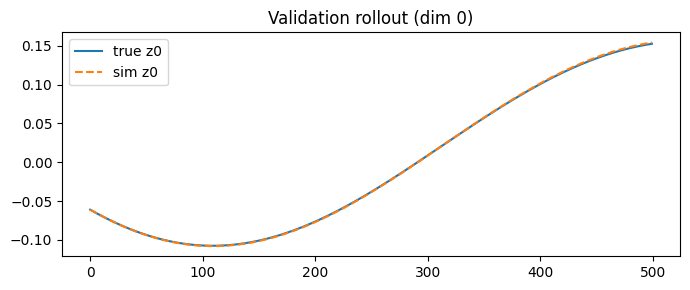

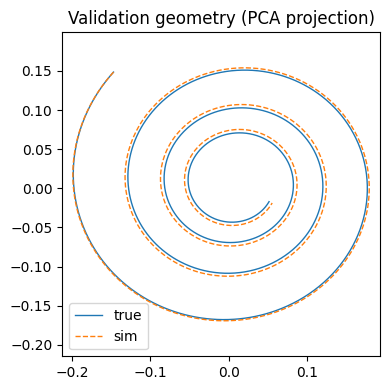

In [14]:
Xi = best["Xi"]
Zhat = euler_rollout(Z_va[0], Xi, T=Z_va.shape[0], dt=DT, poly_order=poly_order)

plt.figure(figsize=(7,3))
plt.plot(Z_va[:500, 0], label="true z0")
plt.plot(Zhat[:500, 0], "--", label="sim z0")
plt.legend()
plt.title("Validation rollout (dim 0)")
plt.tight_layout()
plt.show()

# --- Geometry comparison in a data-driven 2D projection (PCA) ---
if Z_va.shape[1] >= 2:
    from sklearn.decomposition import PCA

    Tplot = min(3000, Z_va.shape[0])
    Zt = Z_va[:Tplot]
    Zm = Zhat[:Tplot]

    pca = PCA(n_components=2)
    Zt2 = pca.fit_transform(Zt)   # fit projection on TRUE data
    Zm2 = pca.transform(Zm)

    plt.figure(figsize=(4,4))
    plt.plot(Zt2[:,0], Zt2[:,1], label="true", lw=1)
    plt.plot(Zm2[:,0], Zm2[:,1], "--", label="sim", lw=1)
    plt.legend()
    plt.title("Validation geometry (PCA projection)")
    plt.axis("equal")
    plt.tight_layout()
    plt.show()

